In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/k9zhou/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
df= pd.read_csv('SampledPornhubDb.csv')
df=df.drop(columns=['Embed Link','Thumbnail URL'])

In [3]:
df.head()

,Title,Tags,Categories,Pornstars,duration (seconds),views,likes,dislikes
0,hollie being a slut,hollie;fat;slut;cum-eating;slave;humiliating;h...,Fetish,NaN,417,898,NaN,NaN
1,Hot babe gets body caressed,teen;hardcore;blowjob;amateurs;euro;russian;te...,Amateur;Hardcore;Teen,NaN,317,1040,NaN,NaN
2,Slut takes rides it deep,teenhitchhikers.com;ass;chubby;riding;blonde;c...,Blonde;Hardcore,NaN,60,76247,85.0,26.0
3,Lexi Belle Is One Sexy Bitch,small-tits;pornstar;blonde;teen;fishnet;teasin...,Pornstar;Teen;Small Tits;Rough Sex,Lexi Belle;Mick Blue,1633,1830089,1741.0,273.0
4,Panty and Ass Worship,fetish;panties;ass;suffocation;pigtails;braces,Fetish;Teen,NaN,285,26322,33.0,12.0


In [4]:
#take a look at views
df['views'].describe()

count    8.440660e+05
mean     4.145755e+04
std      4.125756e+05
min      0.000000e+00
25%      1.740000e+02
50%      8.780000e+02
75%      7.293000e+03
max      7.389239e+07
Name: views, dtype: float64

Pornhub pays 0.69 dollar for every 1000 views, so 100,000 views make 69 dollars, 1 million (1,000,000) views make 690 dollars. 

Over 75% of the videos in our dataset have fewer than 10,000 views, which make only 6.9 dollars. It is really hard to make full-time income from these videos. In order to have enough data to show and compare later, here we define 100,000 views to be successful.

In [5]:
#classify videos into successful and unsuccessful
def success(views):
    if views >= 100000:
        out= 'yes'
    else:
        out= 'no'
    return out

success=df['views'].apply(success)
success=success.rename('success').reset_index().drop(columns='index')

In [6]:
#take a look at the number of successful videos
success.value_counts()

success
no         795200
yes         48866
Name: count, dtype: int64

In [7]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [8]:
#determine the sentiment of tags
def sentiment(tag):
    tag=str(tag).replace(';',' ')
    score= analyzer.polarity_scores(tag)['compound']
    if score>0:
        out='positive'
    elif score<0:
        out='negative'
    else:
        out='neutral'
    return out

sentiment=df['Tags'].apply(sentiment)
sentiment=sentiment.rename('sentiment').reset_index().drop(columns='index')

In [9]:
#determine whether the video has a transgender tag
def transgender(tag):
    tag=str(tag).replace(';',' ')
    if 'tran'in tag or 'trap' in tag or 'shemale'in tag or 'ladyboy'in tag or 'sissy' in tag or 'ftm'in tag or 'mtf' in tag or 'femboy' in tag or 'shecock' in tag:
        out='yes'
    else:
        out='no'
    return out

transgender=df['Tags'].apply(transgender)
transgender=transgender.rename('transgender').reset_index().drop(columns='index')

In [10]:
transgender.value_counts()

transgender
no             818364
yes             25702
Name: count, dtype: int64

In [11]:
#make a new dataframe containing classified information
df2=pd.concat([transgender, sentiment, success],axis=1)

In [12]:
#take a look at the dataframe
df2

,transgender,sentiment,success
0,no,negative,no
1,no,neutral,no
2,no,negative,no
3,no,positive,yes
4,no,negative,no
...,...,...,...
844061,yes,neutral,no
844062,no,neutral,no
844063,no,neutral,no
844064,no,neutral,no


In [13]:
prop=df2['success'].groupby(by=df2['sentiment']).value_counts(normalize=True).reset_index()
prop

,sentiment,success,proportion
0,negative,no,0.926930
1,negative,yes,0.073070
2,neutral,no,0.948463
3,neutral,yes,0.051537
4,positive,no,0.908260
5,positive,yes,0.091740


<AxesSubplot:xlabel='success', ylabel='proportion'>

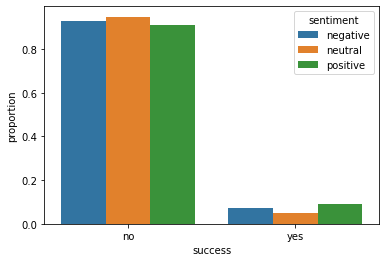

In [14]:
plot=sns.barplot(data=prop, x='success', y='proportion', hue='sentiment')
plot

Among all the videos, videos with neutral tags are least likely to become successful, and videos with positive tags are the most likely to become successful.

In [15]:
prop_trans=df2[df2['transgender']=='yes']['success'].groupby(by=df2[df2['transgender']=='yes']['sentiment']).value_counts(normalize=True).reset_index()
prop_trans

,sentiment,success,proportion
0,negative,no,0.931054
1,negative,yes,0.068946
2,neutral,no,0.930766
3,neutral,yes,0.069234
4,positive,no,0.880923
5,positive,yes,0.119077


<AxesSubplot:xlabel='success', ylabel='proportion'>

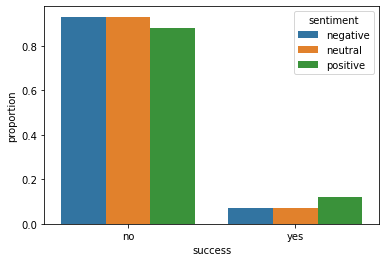

In [16]:
plot_trans=sns.barplot(data=prop_trans, x='success',y='proportion',hue='sentiment')
plot_trans

When looking at transgender videos, results are slightly different. Positive tags again lead to most success. However, the proportion of successful videos with neutral tags is increased a lot, tied with negative tags.

Regression Analysis

In [17]:
import seaborn as sns
import patsy
import statsmodels.api as sm

In [18]:
tag_str=[str(tag).replace(';',' ') for tag in df['Tags']]
df['score']=[analyzer.polarity_scores(tag)['compound'] for tag in tag_str]

df['score']

0        -0.9022
1         0.0000
2        -0.5423
3         0.5267
4        -0.5423
           ...  
844061    0.0000
844062    0.0000
844063    0.0000
844064    0.0000
844065   -0.5423
Name: score, Length: 844066, dtype: float64

In [24]:
def income(views):
    if views >= 1000:
        out=views//1000*0.69
    else:
        out=0
    return out

df['income']=df['views'].apply(income)

In [25]:
df['like_ratio']=df['likes']/(df['likes']+df['dislikes'])
df['success']=df2['success']
df['sentiment']=df2['sentiment']
df['transgender']=df2['transgender']

df.columns=['Title', 'Tags', 'Categories', 'Pornstars', 'duration',
       'views', 'likes', 'dislikes', 'score', 'like_ratio', 'success',
       'sentiment', 'transgender', 'income']

#df=df[df['income']>0]
#df3=df.dropna(subset='like_ratio')
#df_success=df[df['success']=='yes']
df

,Title,Tags,Categories,Pornstars,duration,views,likes,dislikes,score,like_ratio,success,sentiment,transgender,income
0,hollie being a slut,hollie;fat;slut;cum-eating;slave;humiliating;h...,Fetish,NaN,417,898,NaN,NaN,-0.9022,NaN,no,negative,no,0.00
1,Hot babe gets body caressed,teen;hardcore;blowjob;amateurs;euro;russian;te...,Amateur;Hardcore;Teen,NaN,317,1040,NaN,NaN,0.0000,NaN,no,neutral,no,0.69
2,Slut takes rides it deep,teenhitchhikers.com;ass;chubby;riding;blonde;c...,Blonde;Hardcore,NaN,60,76247,85.0,26.0,-0.5423,0.765766,no,negative,no,52.44
3,Lexi Belle Is One Sexy Bitch,small-tits;pornstar;blonde;teen;fishnet;teasin...,Pornstar;Teen;Small Tits;Rough Sex,Lexi Belle;Mick Blue,1633,1830089,1741.0,273.0,0.5267,0.864449,yes,positive,no,1262.70
4,Panty and Ass Worship,fetish;panties;ass;suffocation;pigtails;braces,Fetish;Teen,NaN,285,26322,33.0,12.0,-0.5423,0.733333,no,negative,no,17.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844061,Femboy gets ate out,femboy;leggings;thick-thighs;peach-butt,Latino;Fetish;Gay;Straight Guys;Amateur;Uncut,NaN,18,237,1.0,0.0,0.0000,1.000000,no,neutral,yes,0.00
844062,Futabu - Episode 2,big-cock;ass-fuck;teenager;young;anime;anal;cr...,Big Dick;Toys;Anal;Hentai;Teen;Transgender;Bar...,NaN,1203,295,1.0,0.0,0.0000,1.000000,no,neutral,no,0.00
844063,gemma3,masturbate;teenager;young,Masturbation;Teen;Japanese,NaN,7120,292,1.0,0.0,0.0000,1.000000,no,neutral,no,0.00
844064,Sex 2020,hfo;hd,Asian;Bondage;Blowjob;Bukkake;Creampie;Cumshot...,NaN,137,157,1.0,1.0,0.0000,0.500000,no,neutral,no,0.00


In [26]:
df_success=df[df['success']=='yes']
df_trans=df[df['transgender']=='yes']
#df_noneutral=df_success[(df_success['sentiment']=='positive')|(df_success['sentiment']=='negative')]
df_trans_success=df_trans[df_trans['success']=='yes']

In [29]:
outcome_1, predictors_1=patsy.dmatrices('views~sentiment',df_success)
mod_1=sm.OLS(outcome_1, predictors_1)
res_1=mod_1.fit()

In [30]:
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  views   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     13.81
Date:                Sun, 10 Dec 2023   Prob (F-statistic):           1.01e-06
Time:                        03:18:09   Log-Likelihood:            -7.6779e+05
No. Observations:               48866   AIC:                         1.536e+06
Df Residuals:                   48863   BIC:                         1.536e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              6.431e+

In [31]:
outcome_2, predictors_2=patsy.dmatrices('views~score+like_ratio',df_trans_success)
mod_2=sm.OLS(outcome_2, predictors_2)
res_2=mod_2.fit()

In [32]:
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:                  views   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     9.921
Date:                Sun, 10 Dec 2023   Prob (F-statistic):           5.18e-05
Time:                        03:18:30   Log-Likelihood:                -28549.
No. Observations:                1860   AIC:                         5.710e+04
Df Residuals:                    1857   BIC:                         5.712e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    1.22e+06   2.59e+05      4.712      0.0

In [33]:
outcome_3, predictors_3=patsy.dmatrices('views~duration',df_trans_success)
mod_3=sm.OLS(outcome_3, predictors_3)
res_3=mod_3.fit()

In [34]:
print(res_3.summary())

                            OLS Regression Results                            
Dep. Variable:                  views   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     4.576
Date:                Sun, 10 Dec 2023   Prob (F-statistic):             0.0326
Time:                        03:19:15   Log-Likelihood:                -28556.
No. Observations:                1860   AIC:                         5.712e+04
Df Residuals:                    1858   BIC:                         5.713e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.413e+05   3.32e+04     13.298      0.0

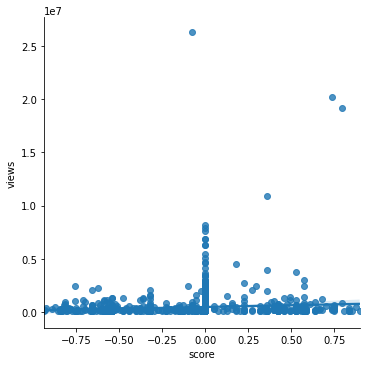

In [35]:
sns.lmplot(data=df_trans_success,x='score',y='views')

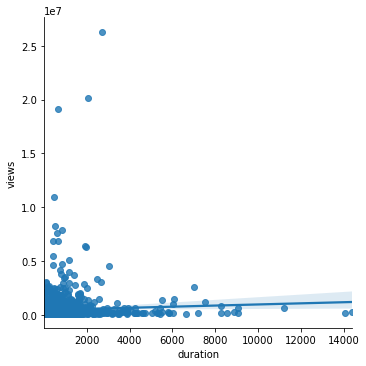

In [36]:
sns.lmplot(data=df_trans_success,x='duration',y='views')